<a href="https://colab.research.google.com/github/Monalika-P/Vision-based-Human-Activity-Recognitio/blob/main/Vision_based_Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9MB 8.5MB/s 


# Importing the libraries

In [1]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import joblib


In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-05-23 07:30:31--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  72.5MB/s    in 43s     

2021-05-23 07:31:15 (71.1 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



# Visualize the Data with its Labels

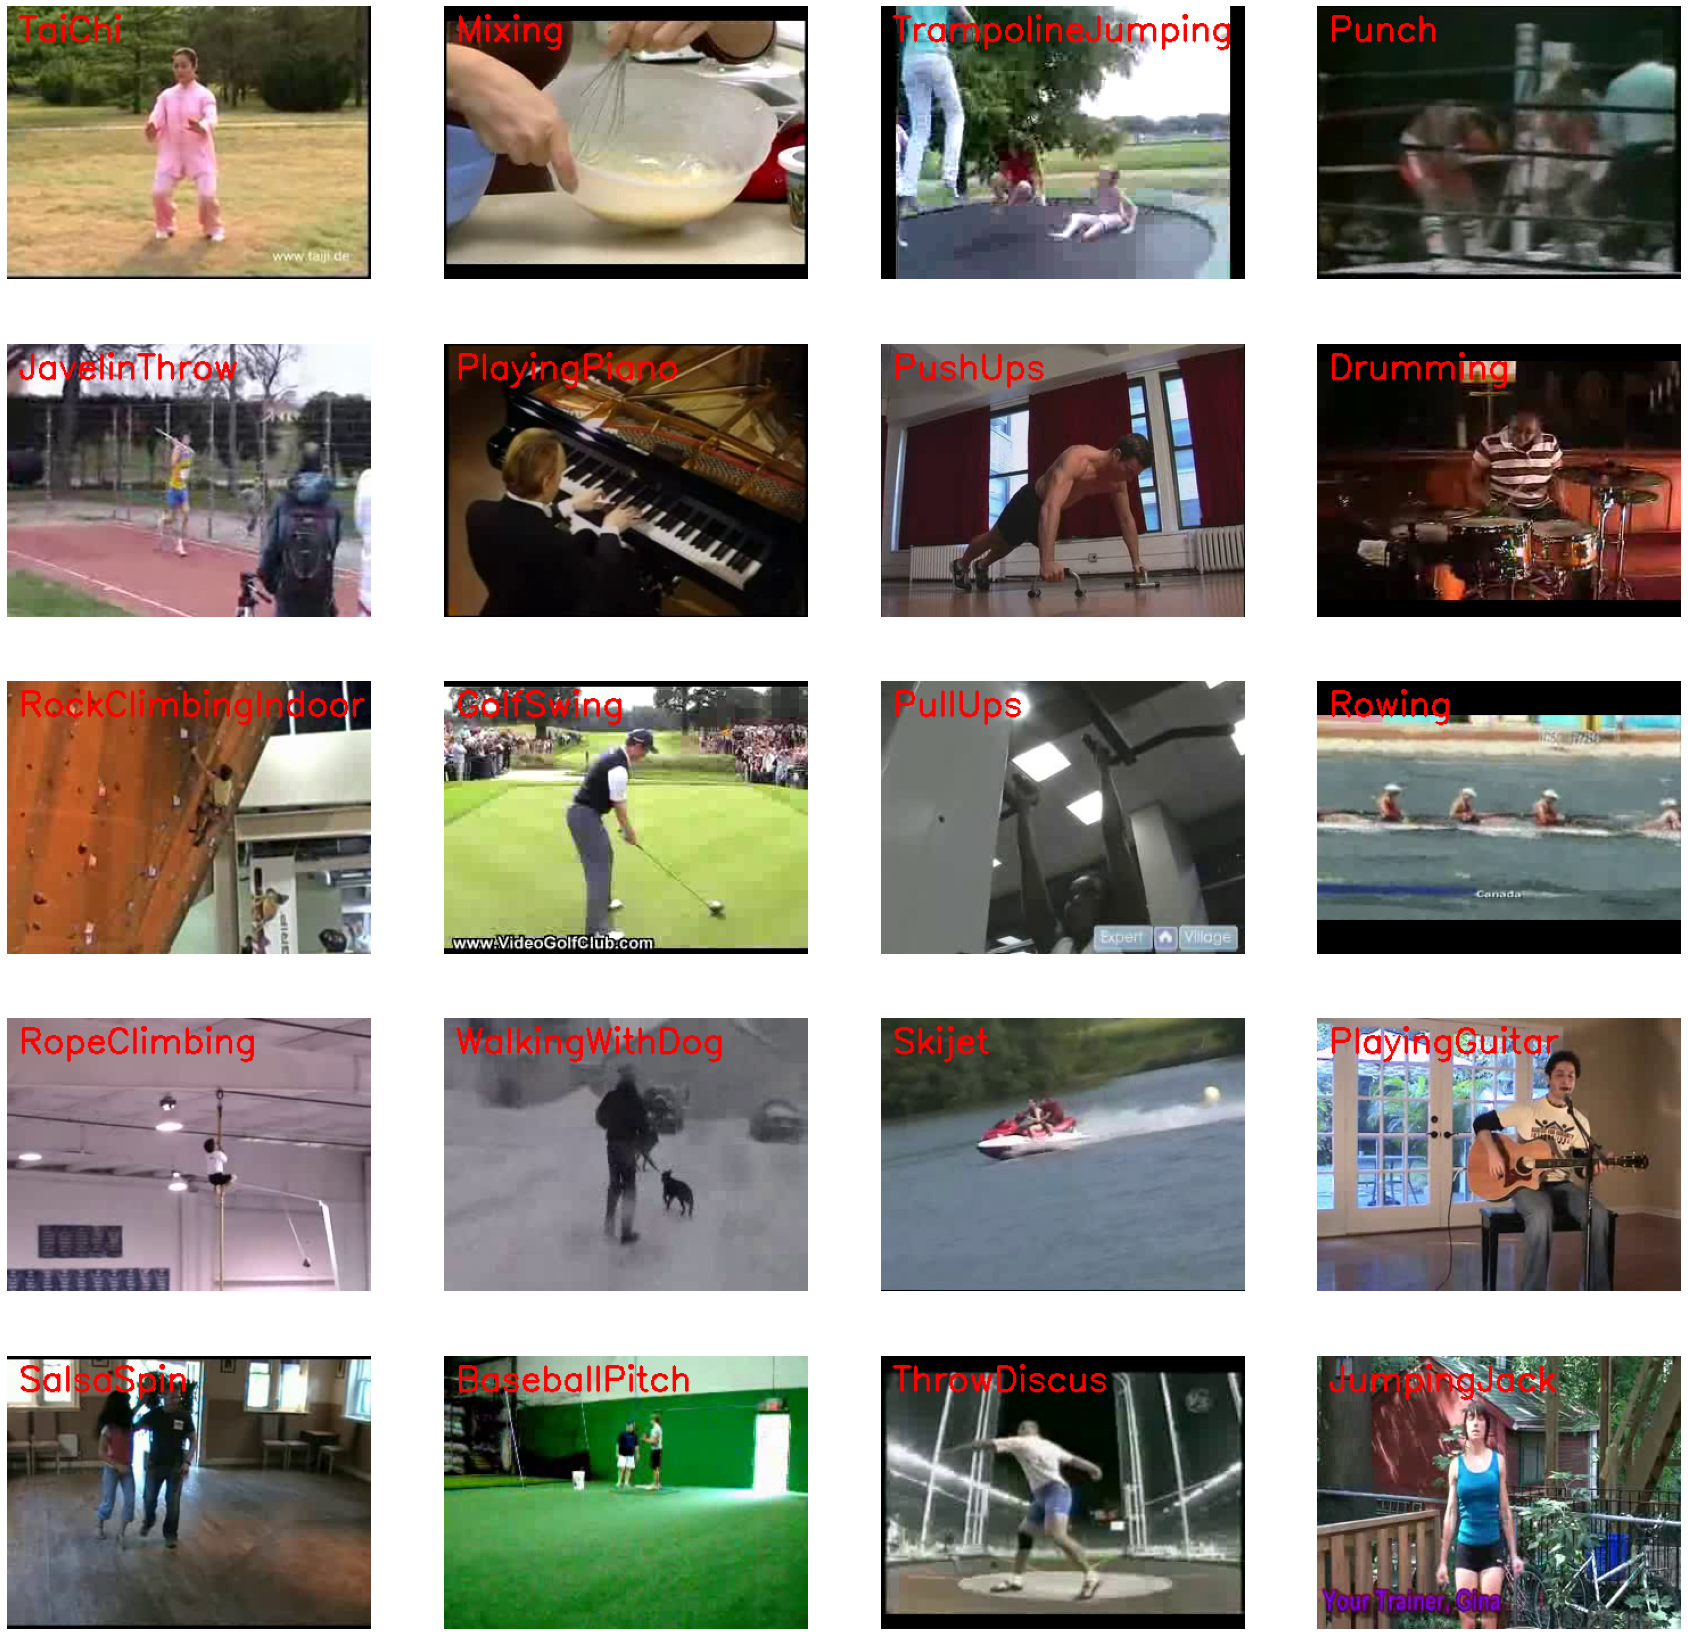

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
# Getting Class Name using Random Index

    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory

    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly selecting a video file

    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File

    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources.

    video_reader.release()
    # Converting the BGR Frame to RGB Frame

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Assigning the Frame to a specific position of a subplot

    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


In [ ]:
c = os.listdir('/content/UCF50')

In [3]:
image_height, image_width = 64, 64
max_images_per_class = 2000
dataset_directory = "UCF50"
classes_list = ['JumpingJack','PlayingViolin','Basketball','HulaHoop','YoYo','TrampolineJumping','VolleyballSpiking','Mixing','PizzaTossing',
                'PlayingPiano','Drumming','Lunges','TennisSwing','Nunchucks','SalsaSpin','PullUps','Punch','ThrowDiscus','PlayingTabla','Rowing']
model_output_size = len(classes_list)

In [ ]:
model_output_size

20

In [4]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    # Iterating through Video Frames
    while True:
    # Reading a frame from the video file
        success, frame = video_reader.read()
        # If Video frame was not successfully read then break the loop

        if not success:
            break

        # Resize the Frame to fixed Dimensions

        resized_frame = cv2.resize(frame, (image_height, image_width))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1

        normalized_frame = resized_frame / 255
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Closing the VideoCapture object and releasing all resources.

    video_reader.release()
    # returning the frames list

    return frames_list


Dataset Creation

In [5]:
def create_dataset():
    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []
    # Iterating through all the classes mentioned in the classes list

    for class_index, class_name in enumerate(classes_list):

        print(f'Extracting Data of Class: {class_name}')
        # Getting the list of video files present in the specific class name directory

        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        # Iterating through all the files present in the files list

        for file_name in files_list:
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
            temp_features.extend(frames)

        features.extend(random.sample(temp_features, max_images_per_class))
        labels.extend([class_index] * max_images_per_class)

        temp_features.clear()

    features = np.asarray(features)

    labels = np.array(labels) 

 

    return features, labels

In [6]:
features, labels = create_dataset()

Extracting Data of Class: JumpingJack
Extracting Data of Class: PlayingViolin
Extracting Data of Class: Basketball
Extracting Data of Class: HulaHoop
Extracting Data of Class: YoYo
Extracting Data of Class: TrampolineJumping
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: Mixing
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingPiano
Extracting Data of Class: Drumming
Extracting Data of Class: Lunges
Extracting Data of Class: TennisSwing
Extracting Data of Class: Nunchucks
Extracting Data of Class: SalsaSpin
Extracting Data of Class: PullUps
Extracting Data of Class: Punch
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: PlayingTabla
Extracting Data of Class: Rowing


In [9]:

joblib.dump(features,'/content/drive/MyDrive/HARModels/features.pickle')

['/content/drive/MyDrive/HARModels/features.pickle']

In [10]:
joblib.dump(labels,'/content/drive/MyDrive/HARModels/labels.pickle')

['/content/drive/MyDrive/HARModels/labels.pickle']

In [4]:
features = joblib.load('/content/drive/MyDrive/HARModels/features.pickle')

In [5]:
labels = joblib.load('/content/drive/MyDrive/HARModels/labels.pickle')

In [6]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [9]:
# Let's create a function that will construct our model
def create_model():
 # We will use a Sequential model for model construction
    model = Sequential()
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (64, 64, 3)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))

    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation = 'relu'))

    model.add(BatchNormalization())

    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary

    model.summary()

    return model
# Calling the create_model method
model = create_model()

print("Model Created Successfully!")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

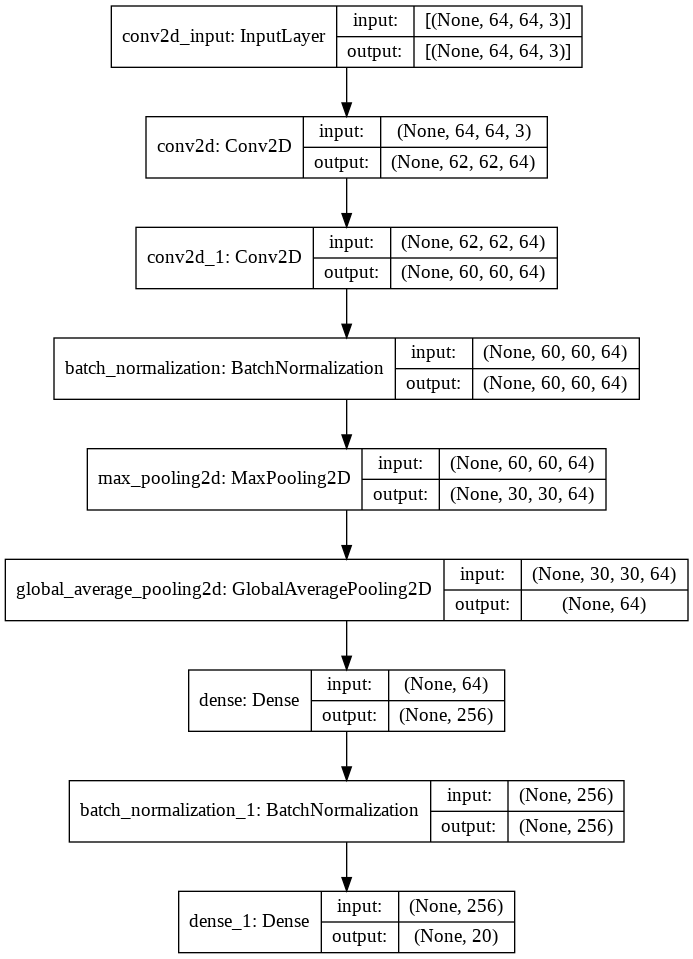

In [10]:
	plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [8]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/HARModels/har.h5')

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
# Adding loss, optimizer and metrics values to the model.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HARModels/har.h5', monitor = 'val_loss', verbose = 1, save_best_only = True,
                                                mode = 'min')
# model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
# Start Training
model_training_history = loaded_model.fit(x = features_train, y = labels_train, epochs = 20 , batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,checkpoint])

Epoch 1/20
477/800 [================>.............] - ETA: 4:17 - loss: 0.0622 - accuracy: 0.9810